### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2020.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,year,Post
0,2020,"It’s Wednesday, And I’m Dreading Going Back To..."
1,2020,A letter to myself: musings during a nervous b...
2,2020,Escapism; It’s ok to seek an escape.This is my...
3,2020,My Top 10 Panic Attacks of the Decade(1 of 10)...
4,2020,Saying NO to Anxious Love and other lessons fr...


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['it', 'wednesday', 'and', 'dreading', 'going', 'back', 'to', 'worki', 'like', 'my', 'job', 'but', 'also', 'think', 've', 'never', 'quite', 'dreaded', 'job', 'as', 'much', 'as', 'sometimes', 'dread', 'this', 'one', 'remember', 'when', 'worked', 'at', 'the', 'gym', 'was', 'saying', 'to', 'coworker', 'one', 'day', 'it', 'really', 'hard', 'to', 'find', 'job', 'you', 'don', 'dread', 'coming', 'to', 'every', 'day', 'or', 'that', 'you', 'don', 'feel', 'like', 'you', 'need', 'to', 'take', 'time', 'away', 'from', 'and', 'that', 'what', 'it', 'was', 'like', 'to', 'work', 'there', 'here', 'sometimes', 'dread', 'going', 'and', 'often', 'feel', 'like', 'might', 'need', 'to', 'take', 'time', 'away', 'because', 'can', 'feel', 'the', 'stress', 'getting', 'to', 'me', 'those', 'were', 'pretty', 'few', 'and', 'far', 'between', 'though', 'which', 'is', 'good', 'because', 'wasn', 'even', 'in', 'program', 'that', 'would', 'warrant', 'such', 'stress', 'didn', 'study', 'law', 'wasn', 'pre', 'med', 'studied'

In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['it', 'wednesday', 'and', 'dreading', 'going', 'back', 'to', 'worki', 'like', 'my', 'job', 'but', 'also', 'think', 've', 'never', 'quite', 'dreaded', 'job', 'as', 'much', 'as', 'sometimes', 'dread', 'this', 'one', 'remember', 'when', 'worked', 'at', 'the', 'gym', 'was', 'saying', 'to', 'coworker', 'one', 'day', 'it', 'really', 'hard', 'to', 'find', 'job', 'you', 'don', 'dread', 'coming', 'to', 'every', 'day', 'or', 'that', 'you', 'don', 'feel', 'like', 'you', 'need', 'to', 'take', 'time', 'away', 'from', 'and', 'that', 'what', 'it', 'was', 'like', 'to', 'work', 'there', 'here', 'sometimes', 'dread', 'going', 'and', 'often', 'feel', 'like', 'might', 'need', 'to', 'take', 'time', 'away', 'because', 'can', 'feel', 'the', 'stress', 'getting', 'to', 'me', 'those', 'were', 'pretty', 'few', 'and', 'far', 'between', 'though', 'which', 'is', 'good', 'because', 'wasn', 'even', 'in', 'program', 'that', 'would', 'warrant', 'such', 'stress', 'didn', 'study', 'law', 'wasn', 'pre', 'med', 'studied',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# data_words_nostops = remove_stopwords(data_words)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load("en_core_web_sm")

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized[:1])

# # Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [31]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"pandemic" + 0.019*"people" + 0.015*"covid" + 0.013*"home" + '
  '0.010*"news" + 0.009*"family" + 0.009*"new" + 0.008*"world" + 0.007*"many" '
  '+ 0.007*"live"'),
 (1,
  '0.029*"stress" + 0.024*"body" + 0.019*"help" + 0.015*"mind" + '
  '0.013*"practice" + 0.013*"sleep" + 0.013*"meditation" + 0.012*"exercise" + '
  '0.011*"calm" + 0.010*"breathing"'),
 (2,
  '0.053*"anxiety" + 0.013*"stress" + 0.012*"disorder" + 0.010*"cause" + '
  '0.010*"symptom" + 0.010*"also" + 0.009*"study" + 0.008*"brain" + '
  '0.008*"experience" + 0.007*"increase"'),
 (3,
  '0.021*"रह" + 0.020*"नह" + 0.020*"और" + 0.020*"तमह" + 0.014*"पर" + '
  '0.012*"कय" + 0.011*"करन" + 0.011*"अपन" + 0.011*"डर" + 0.010*"एक"'),
 (4,
  '0.021*"work" + 0.014*"time" + 0.011*"write" + 0.009*"make" + 0.008*"book" + '
  '0.008*"new" + 0.007*"day" + 0.007*"read" + 0.007*"good" + 0.007*"also"'),
 (5,
  '0.025*"que" + 0.017*"dan" + 0.007*"yang" + 0.007*"lo" + 0.007*"untuk" + '
  '0.007*"itu" + 0.006*"com" + 0.006*"para" +

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.43795514408985


In [34]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49243328641793455


In [35]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.4360,"go, feel, know, day, get, time, make, say, tak...","[wednesday, dread, go, back, worki, job, also,..."
1,1,8.0,0.4552,"go, feel, know, day, get, time, make, say, tak...","[letter, musing, nervous, breakdowni, find, le..."
2,2,8.0,0.4368,"go, feel, know, day, get, time, make, say, tak...","[escapism, seek, escape, attempt, share, way, ..."
3,3,8.0,0.4869,"go, feel, know, day, get, time, make, say, tak...","[top, panic_attack, decade, summer, birthright..."
4,4,4.0,0.3791,"work, time, write, make, book, new, day, read,...","[say, anxious, love, lesson, last, decade, str..."


In [37]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.4360,"go, feel, know, day, get, time, make, say, tak...","[wednesday, dread, go, back, worki, job, also,..."
1,1,8.0,0.4552,"go, feel, know, day, get, time, make, say, tak...","[letter, musing, nervous, breakdowni, find, le..."
2,2,8.0,0.4368,"go, feel, know, day, get, time, make, say, tak...","[escapism, seek, escape, attempt, share, way, ..."
3,3,8.0,0.4869,"go, feel, know, day, get, time, make, say, tak...","[top, panic_attack, decade, summer, birthright..."
4,4,4.0,0.3791,"work, time, write, make, book, new, day, read,...","[say, anxious, love, lesson, last, decade, str..."
...,...,...,...,...,...
12473,12473,8.0,0.5130,"go, feel, know, day, get, time, make, say, tak...","[depth, last, night, try, see, video, online, ..."
12474,12474,7.0,0.3117,"anxiety, feel, thing, people, make, life, time...","[silent, scream, helpmore, often, find, keep, ..."
12475,12475,8.0,0.5779,"go, feel, know, day, get, time, make, say, tak...","[anxietyit, happen, life, mind, control, mine,..."
12476,12476,8.0,0.3681,"go, feel, know, day, get, time, make, say, tak...","[vent, dec, amount, fear, hate, dislike, immea..."


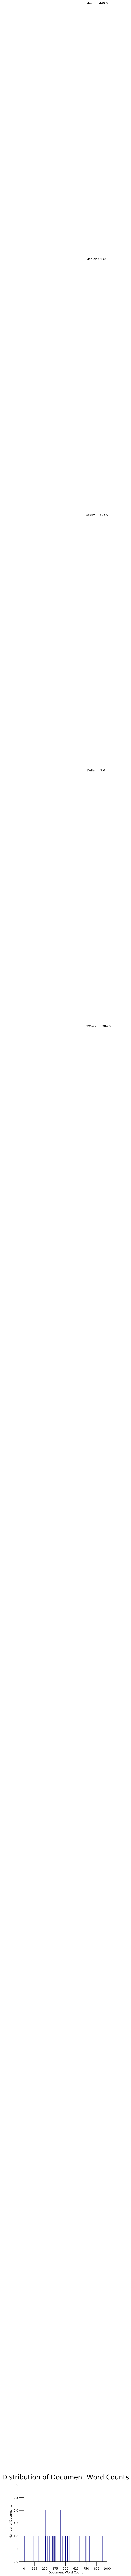

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

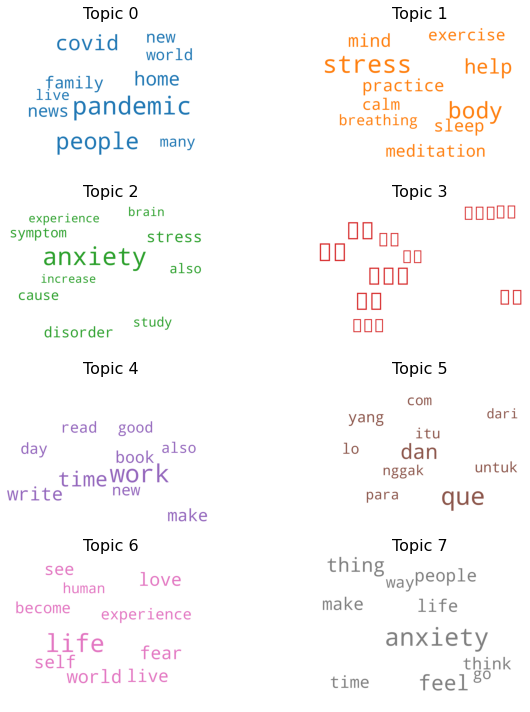

In [38]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [28]:
df_dominant_topic.to_csv("Medium2020.csv")

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=8):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=8)

(10, 0.14291056471719066, 0.457662964971577)

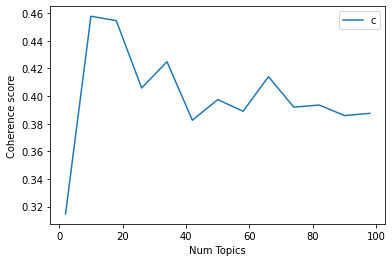

In [29]:
# Show graph
limit=100; start=2; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)